# Pytorch Custom Datasets

## Importing PyTorch and Setting Up Device-Agnostic Code

In [1]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Sun May 28 17:31:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image folder doesn't exist, download and prepare
if image_path.is_dir():
  print(f"{image_path} directory already exists.")
else:
  print(f"{image_path} directory doesn't exist, creating one!")
  image_path.mkdir(parents=True, exist_ok=True)

# Dowload data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading data!")
  f.write(request.content)

# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping data!")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't exist, creating one!
Unzipping data!


## Data Preparation

In [5]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi.
There are 3 directories and 0 images in data/pizza_steak_sushi/test.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
There are 3 directories and 0 images in data/pizza_steak_sushi/train.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualize Data
1. Get all of the image paths
2. Pick random image path using `random.choice()`
3. Get image class name using `pathlib.Path.parent.stem`
4. Open random image path using `PIL.Image.open()`
5. Show image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/2785084.jpg
Image Class: pizza


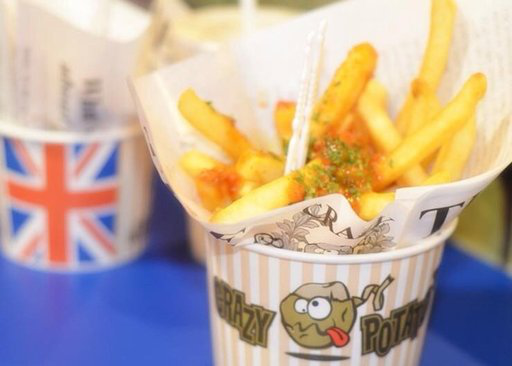

In [8]:
import random
from PIL import Image

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class name
image_class = random_image_path.parent.stem

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
img

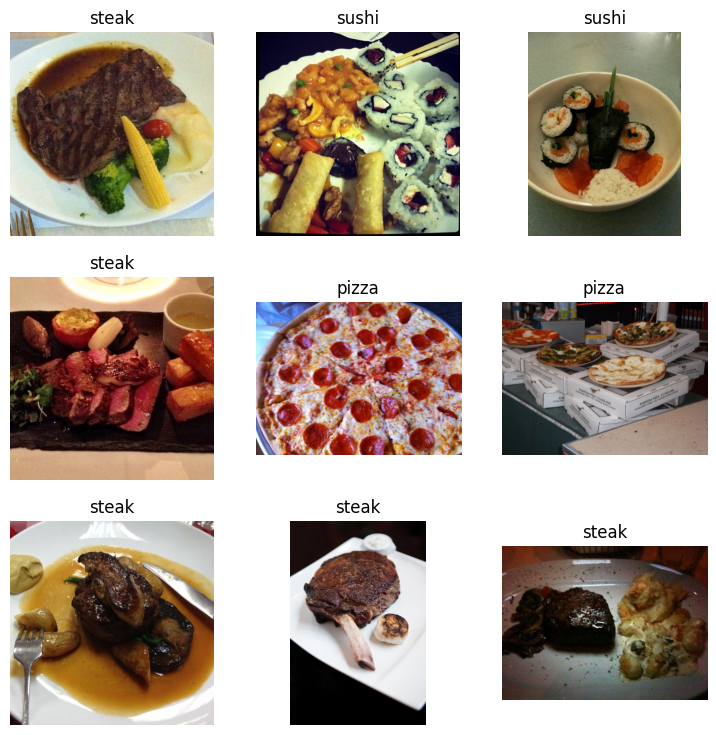

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows*cols + 1):
  random_image_path = random.choice(image_path_list)
  image_class = random_image_path.parent.stem
  img = Image.open(random_image_path)

  fig .add_subplot(rows, cols, i)
  plt.imshow(np.asarray(img))
  plt.title(image_class)
  plt.axis(False)

## Transform Data
1. Turn into tensors
2. Turn into `torch.utils.data.DataSet` and `torch.utils.data.DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn image into torch.Tensor
    transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [13]:
def plot_transformed_images(image_paths, transform, n=3):
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

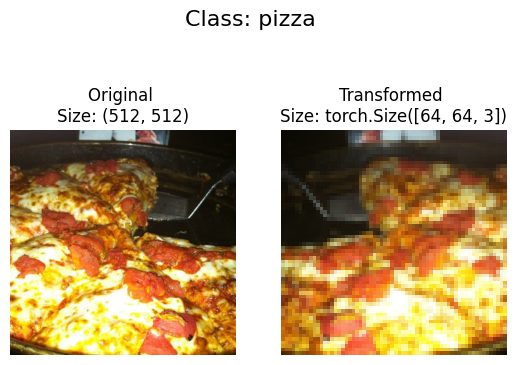

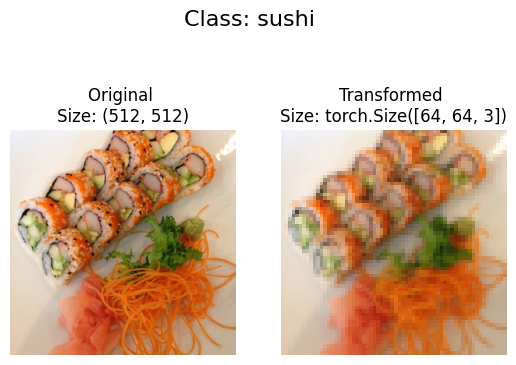

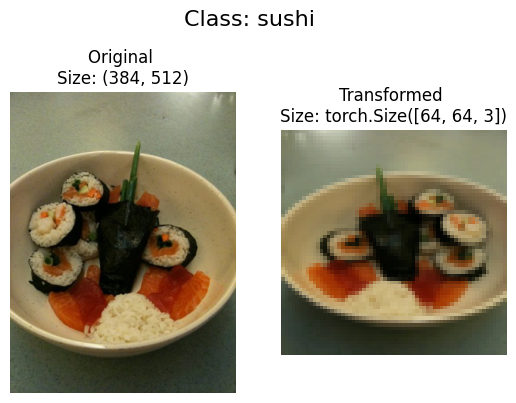

In [14]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

## Loading Image Data Using `ImageFolder`

In [15]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [16]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64])
Image permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

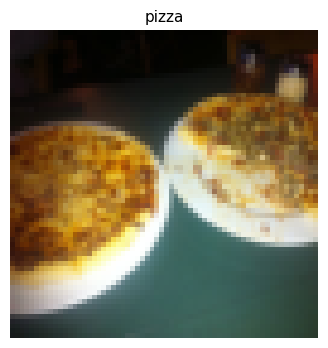

In [20]:
# Rearrange order of dimensions (matplotlib likes color channels last)
img_permute = img.permute(1, 2, 0)

# Print out shapes
print(f"Original shape: {img.shape}")
print(f"Image permute shape: {img_permute.shape}")

# Plot image
plt.figure(figsize=(7, 4))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=11)

### Turn loaded images into `DataLoader`'s

In [21]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8eb2a940a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8eb273a4a0>)

In [22]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape}")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([32, 3, 64, 64])
Label Shape: torch.Size([32])


## Loading Image Data Using Custom `Dataset`

In [24]:
import os
import pathlib

from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating Helper Function to Get Class Names
1. Get class names using `os.scandir()` to traverse target directory
2. Raise error if class names aren't found
3. Turn class names into dict and list, and return them

In [26]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get class names from target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
print(f"Class names found: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")

  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

In [28]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create Custom `Dataset` to replicate `ImageFolder`
1. Subclass `torch.utils.data.Dataset`
2. Init subclass with a target directory
3. Create several attributes: paths, transform, classes, class_to_idx
4. Create function to load images from file and return them

In [29]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None) -> None:
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)
  
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [30]:
from torchvision import transforms

# Create a transform
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [31]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [32]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f8eb273a7a0>,
 <__main__.ImageFolderCustom at 0x7f8eb27382e0>)

In [33]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [34]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [35]:
# Check for equality
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### Create Function to Display Random Images

In [36]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True):
  
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10!!")

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_image_adjust.shape}"
    plt.title(title)

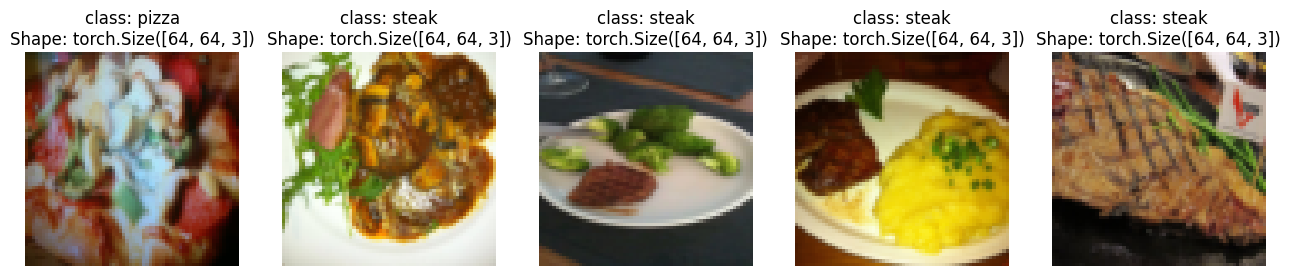

In [37]:
display_random_images(train_data,
                      n=5,
                      classes=class_names)

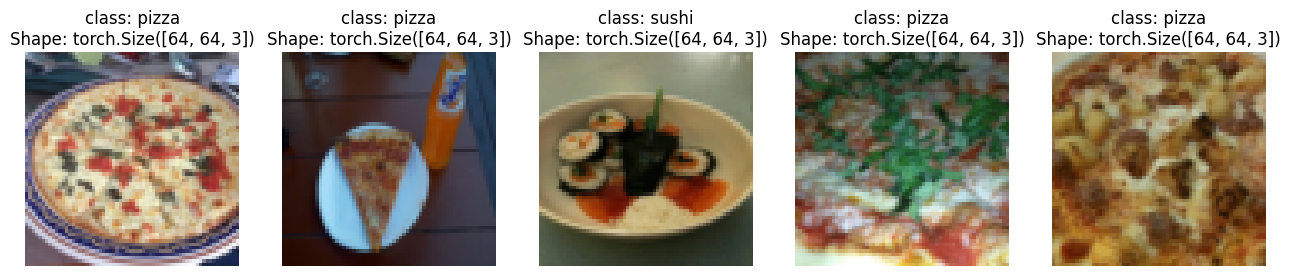

In [38]:
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names)

### Turn Custom Loaded Images Into `DataLoader`'s

In [39]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f8eb24bd3f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8eb24be890>)

In [40]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image Shape: {img_custom.shape}")
print(f"Label Shape: {label_custom.shape}")

Image Shape: torch.Size([32, 3, 64, 64])
Label Shape: torch.Size([32])


## Data Augmentation

In [41]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])

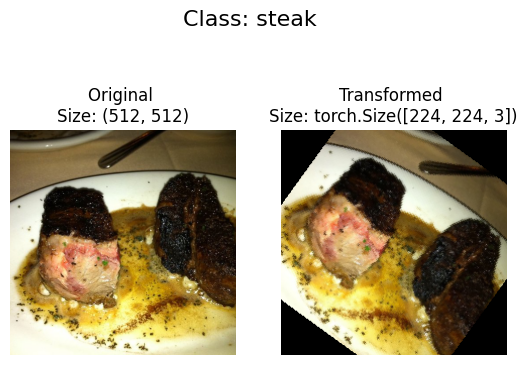

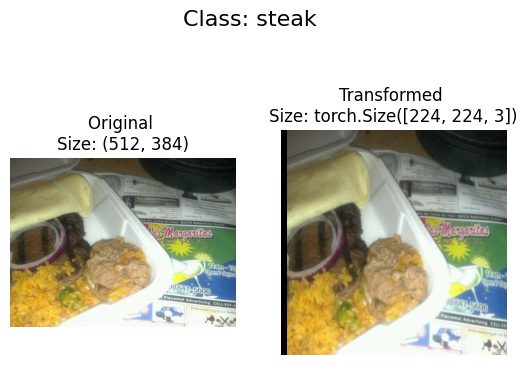

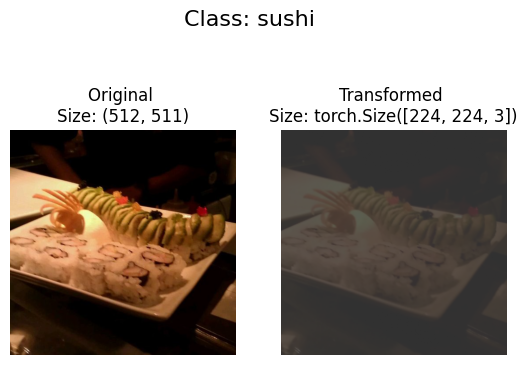

In [42]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3
)

## Model 0: TinyVGG w/o Data Augmentation

### Create Transforms and Load Data

In [43]:
# Simple transform
simple_transform = transforms.Compose([transforms.Resize((64, 64)),
                                       transforms.ToTensor()])

In [44]:
# Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f8eb2ac6d10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8eb24be410>)

### Create TinyVGG Model Class

In [45]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*169,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [46]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try Forward Pass On Single Image

In [47]:
# Get single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [48]:
model_0(image_batch.to(device))

tensor([[-0.0168, -0.0208, -0.0468],
        [-0.0138, -0.0173, -0.0441],
        [-0.0131, -0.0201, -0.0452],
        [-0.0157, -0.0188, -0.0457],
        [-0.0141, -0.0174, -0.0457],
        [-0.0131, -0.0181, -0.0475],
        [-0.0120, -0.0172, -0.0470],
        [-0.0163, -0.0196, -0.0483],
        [-0.0148, -0.0187, -0.0457],
        [-0.0165, -0.0188, -0.0468],
        [-0.0141, -0.0168, -0.0450],
        [-0.0141, -0.0170, -0.0478],
        [-0.0121, -0.0171, -0.0485],
        [-0.0152, -0.0181, -0.0468],
        [-0.0144, -0.0184, -0.0458],
        [-0.0152, -0.0222, -0.0447],
        [-0.0148, -0.0183, -0.0449],
        [-0.0134, -0.0175, -0.0479],
        [-0.0146, -0.0184, -0.0469],
        [-0.0136, -0.0198, -0.0471],
        [-0.0154, -0.0168, -0.0462],
        [-0.0159, -0.0187, -0.0459],
        [-0.0151, -0.0187, -0.0459],
        [-0.0141, -0.0165, -0.0474],
        [-0.0135, -0.0164, -0.0454],
        [-0.0129, -0.0181, -0.0465],
        [-0.0137, -0.0160, -0.0456],
 

### Use `torchinfo` to Understand Model

In [49]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Create Train and Test Loop Functions

In [131]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [138]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### Functionize Train Function

In [139]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  
  # Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through training and testing steps
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
        
    # Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### Train and Evaluate Model 0

In [159]:
NUM_EPOCHS = 5

# Recreate instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End timer and print how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1113 | Train acc: 0.2930 | Test loss: 1.1117 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.1036 | Train acc: 0.2734 | Test loss: 1.0831 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0873 | Train acc: 0.4688 | Test loss: 1.1004 | Test acc: 0.1979
Epoch: 3 | Train loss: 1.1013 | Train acc: 0.2930 | Test loss: 1.1093 | Test acc: 0.1979
Epoch: 4 | Train loss: 1.0768 | Train acc: 0.3477 | Test loss: 1.0794 | Test acc: 0.4318
Total training time: 9.124 seconds


### Plot Loss Curves

In [160]:
model_0_results["train_loss"]

[1.111270621418953,
 1.103603333234787,
 1.0873021632432938,
 1.1013234555721283,
 1.0767577290534973]

In [161]:
def plot_loss_curves(results: Dict[str, List[float]]):
  # Get loss values of results dictionary
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get accuracy values
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Calculate number of epochs
  epochs = range(len(results["train_loss"]))

  # Setup plot
  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

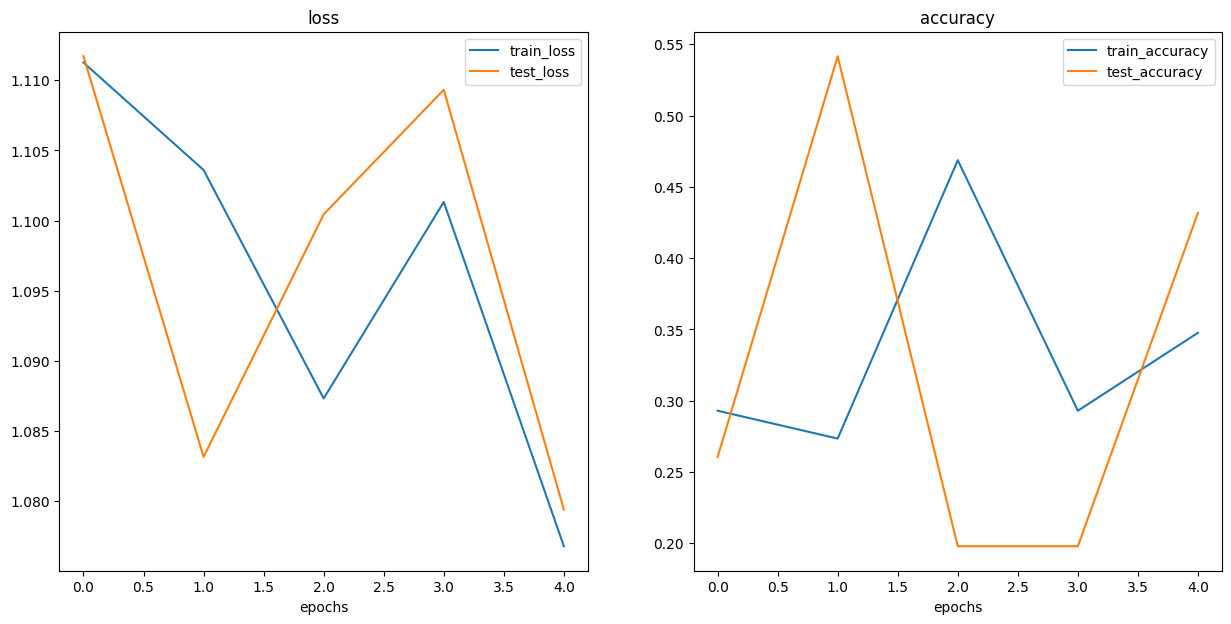

In [162]:
plot_loss_curves(model_0_results)

## Model 1: TinyVGG With Data Augmentation

### Create Transform With Data Augmentation

In [163]:
from torchvision import transforms

train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=5),
                                             transforms.ToTensor()])
test_transform_simple = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.ToTensor()])

### Create Train and Test `Dataset`'s and `DataLoader`'s

In [164]:
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform_simple)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=5, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [165]:
# Turn Datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7f8dfa9c7160>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8dfa9c7e80>)

### Train Model 1

In [240]:
NUM_EPOCHS = 5

model_1 = TinyVGG(input_shape=3, 
                  hidden_units=10, 
                  output_shape=len(train_data_augmented.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
print(f"Model 1 finished training in {end_time-start_time} seconds!")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1047 | Train acc: 0.2539 | Test loss: 1.1059 | Test acc: 0.2396
Epoch: 1 | Train loss: 1.1002 | Train acc: 0.2891 | Test loss: 1.0940 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0989 | Train acc: 0.2812 | Test loss: 1.0962 | Test acc: 0.5417
Epoch: 3 | Train loss: 1.0984 | Train acc: 0.2617 | Test loss: 1.0980 | Test acc: 0.1979
Epoch: 4 | Train loss: 1.1011 | Train acc: 0.2930 | Test loss: 1.0968 | Test acc: 0.5417
Model 1 finished training in 8.246711444000539 seconds!


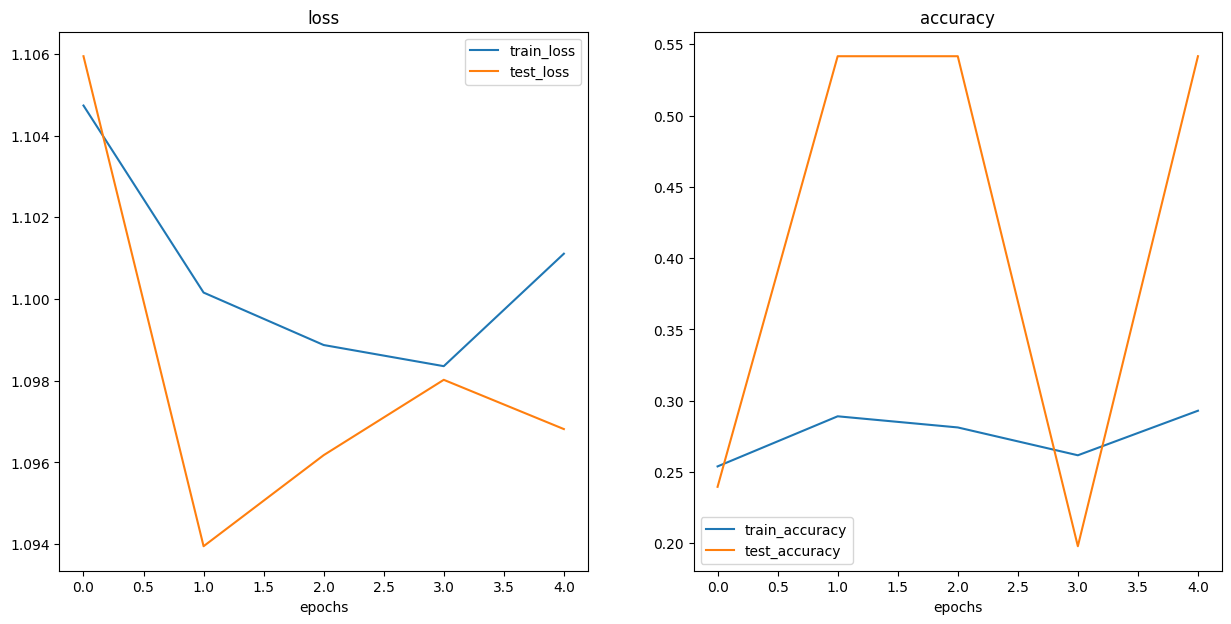

In [241]:
plot_loss_curves(model_1_results)

## Compare Model Results

In [242]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.111271,0.292969,1.111723,0.260417
1,1.103603,0.273438,1.083132,0.541667
2,1.087302,0.468750,1.100440,0.197917
3,1.101323,0.292969,1.109325,0.197917
4,1.076758,0.347656,1.079375,0.431818


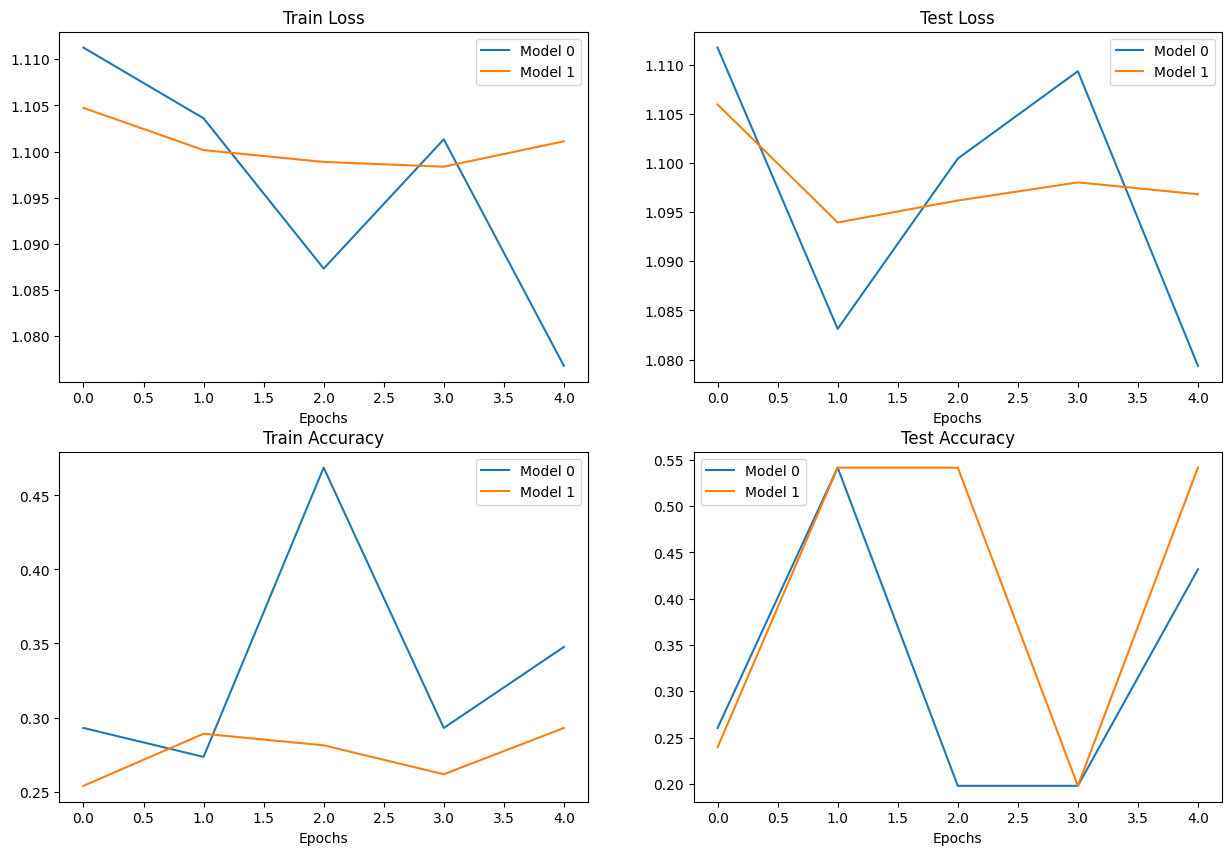

In [243]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## Making Predictions On Custom Images

In [244]:
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}!")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists!")

data/04-pizza-dad.jpeg already exists!


### Loading Custom Image

In [245]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image = custom_image_uint8 / 255

# Print image data
print(f"Custom image tensor:\n{custom_image}")
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

In [246]:
custom_image_transform = transforms.Compose([transforms.Resize((64, 64))])

custom_image_transformed = custom_image_transform(custom_image)

print(f"New Shape: {custom_image_transformed.shape}")

New Shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


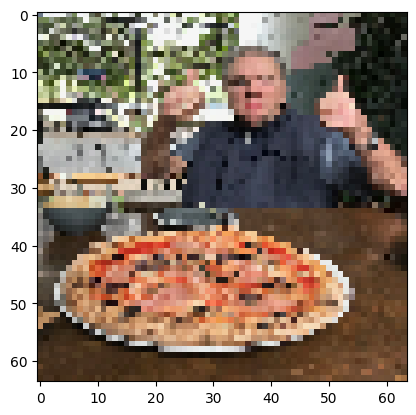

In [247]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [248]:
model_0.eval()
with torch.inference_mode():
  # Add extra dimension to image
  custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)

  custom_image_pred = model_0(custom_image_transformed.to(device))

In [249]:
print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction Probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction Label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.1247,  0.0281, -0.0348]], device='cuda:0')
Prediction Probabilities: tensor([[0.3068, 0.3575, 0.3357]], device='cuda:0')
Prediction Label: tensor([1], device='cuda:0')


In [250]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'steak'

### Functionizing Custom Image Prediction

In [251]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
  
  # Load image and convert tensor values to float 32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  target_image /= 255

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  model.to(device)

  # Make prediction
  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(dim=0)
    target_image_pred = model(target_image.to(device))

  # Logits -> probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Probs -> labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot image alongside predictions
  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu()*100:.2f}%"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu()*100:.2f}%"

  plt.title(title)
  plt.axis(False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


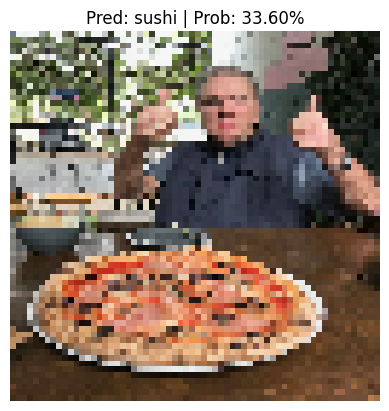

In [255]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)